## 10.4 Stochastic and deterministic trends
There are two different ways of modelling a linear trend. A *deterministic trend* is obtained using the regression model
$$
y_t = \beta_0 + \beta_1t+\eta_t,
$$
where $\eta_t$ is an ARMA process. A *stochastic trend* is obtained using the model
$$
y_t = \beta_0 + \beta_1t+\eta_t,
$$
where $\eta_t$ is an ARIMA process with $d=1$. In the latter case, we can difference both sides so that $y'_t=\beta_1+\eta'_t$, where $\eta_t'$ is an ARMA process. In other words,
$$
y_t = y_{t-1} + \beta_1+\eta'_t.
$$
This is similar to a random walk with drift, but here the error term is an ARMA process rather than simply white noise.

Although these models appear quite similar (they only differ in the number of differences that need to be applied to $\eta_t$), their forecasting characteristics are quite different.

### Example: Air transport passengers Australia

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')
from utils import *

In [4]:
df = pd.read_csv('../data/fpp3/aus_airpassengers.csv')

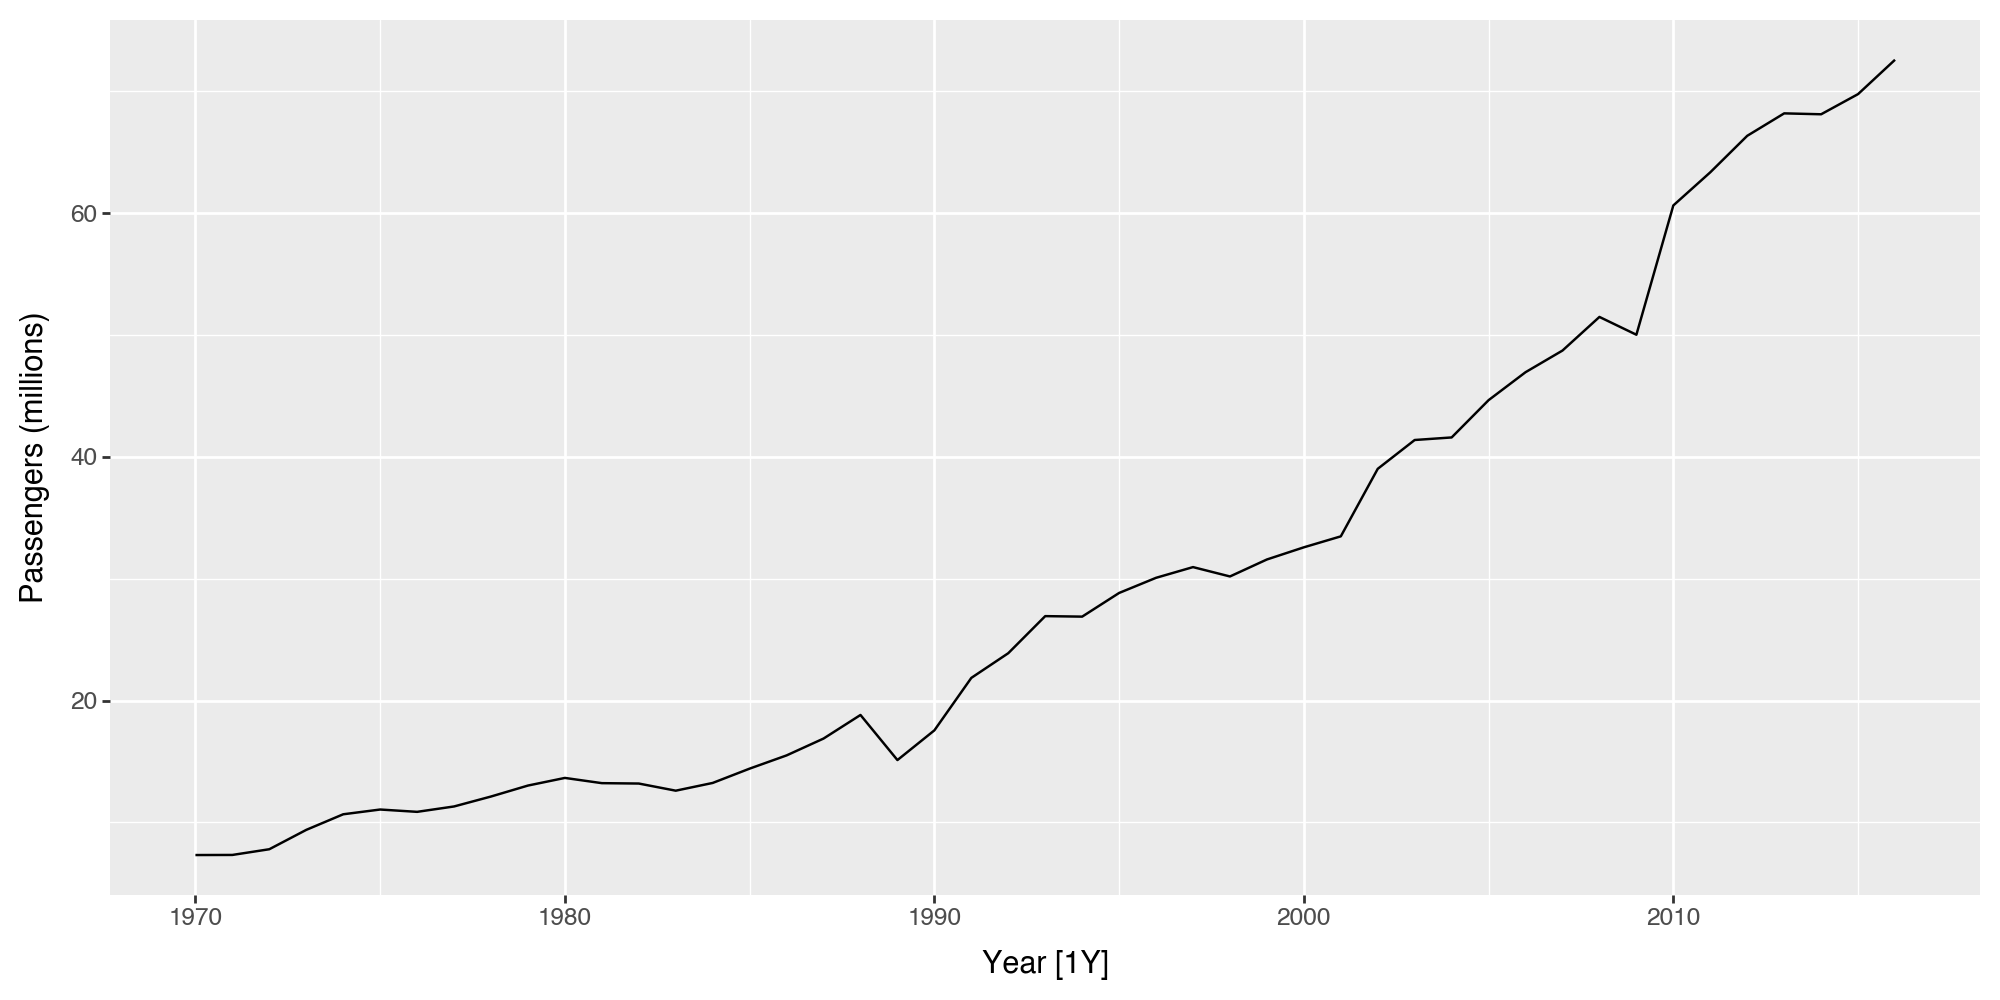

In [8]:
(
    ggplot(df)
    + aes(x="Year", y="Passengers")
    + geom_line()
    + labs(y="Passengers (millions)", x="Year [1Y]")
    + theme(figure_size=(10, 5))
)

We will both a deterministic and stochastic trend model to these data.

In [11]:
passengers = df.assign(Year=pd.to_datetime(df['Year'], format='%Y')).set_index('Year').pipe(set_freq)

In [93]:
fit = sm.tsa.SARIMAX(passengers.Passengers, trend='ct', order=(2,0,0)).fit(disp=0)

In [94]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   47
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -96.549
Date:                Tue, 26 Nov 2024   AIC                            203.098
Time:                        21:08:24   BIC                            212.349
Sample:                    01-01-1970   HQIC                           206.580
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1656      1.052      0.157      0.875      -1.897       2.228
drift          0.1222      0.110      1.113      0.266      -0.093       0.337
ar.L1          0.7988      0.165      4.849      0.000       0.476       1.122
ar.L2          0.1548      0.164      0.946      0.344      -0.166       0.476
sigma2         3.3935      0.656      5.172      0.000       2.107       4.680
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                68.09
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               8.95   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

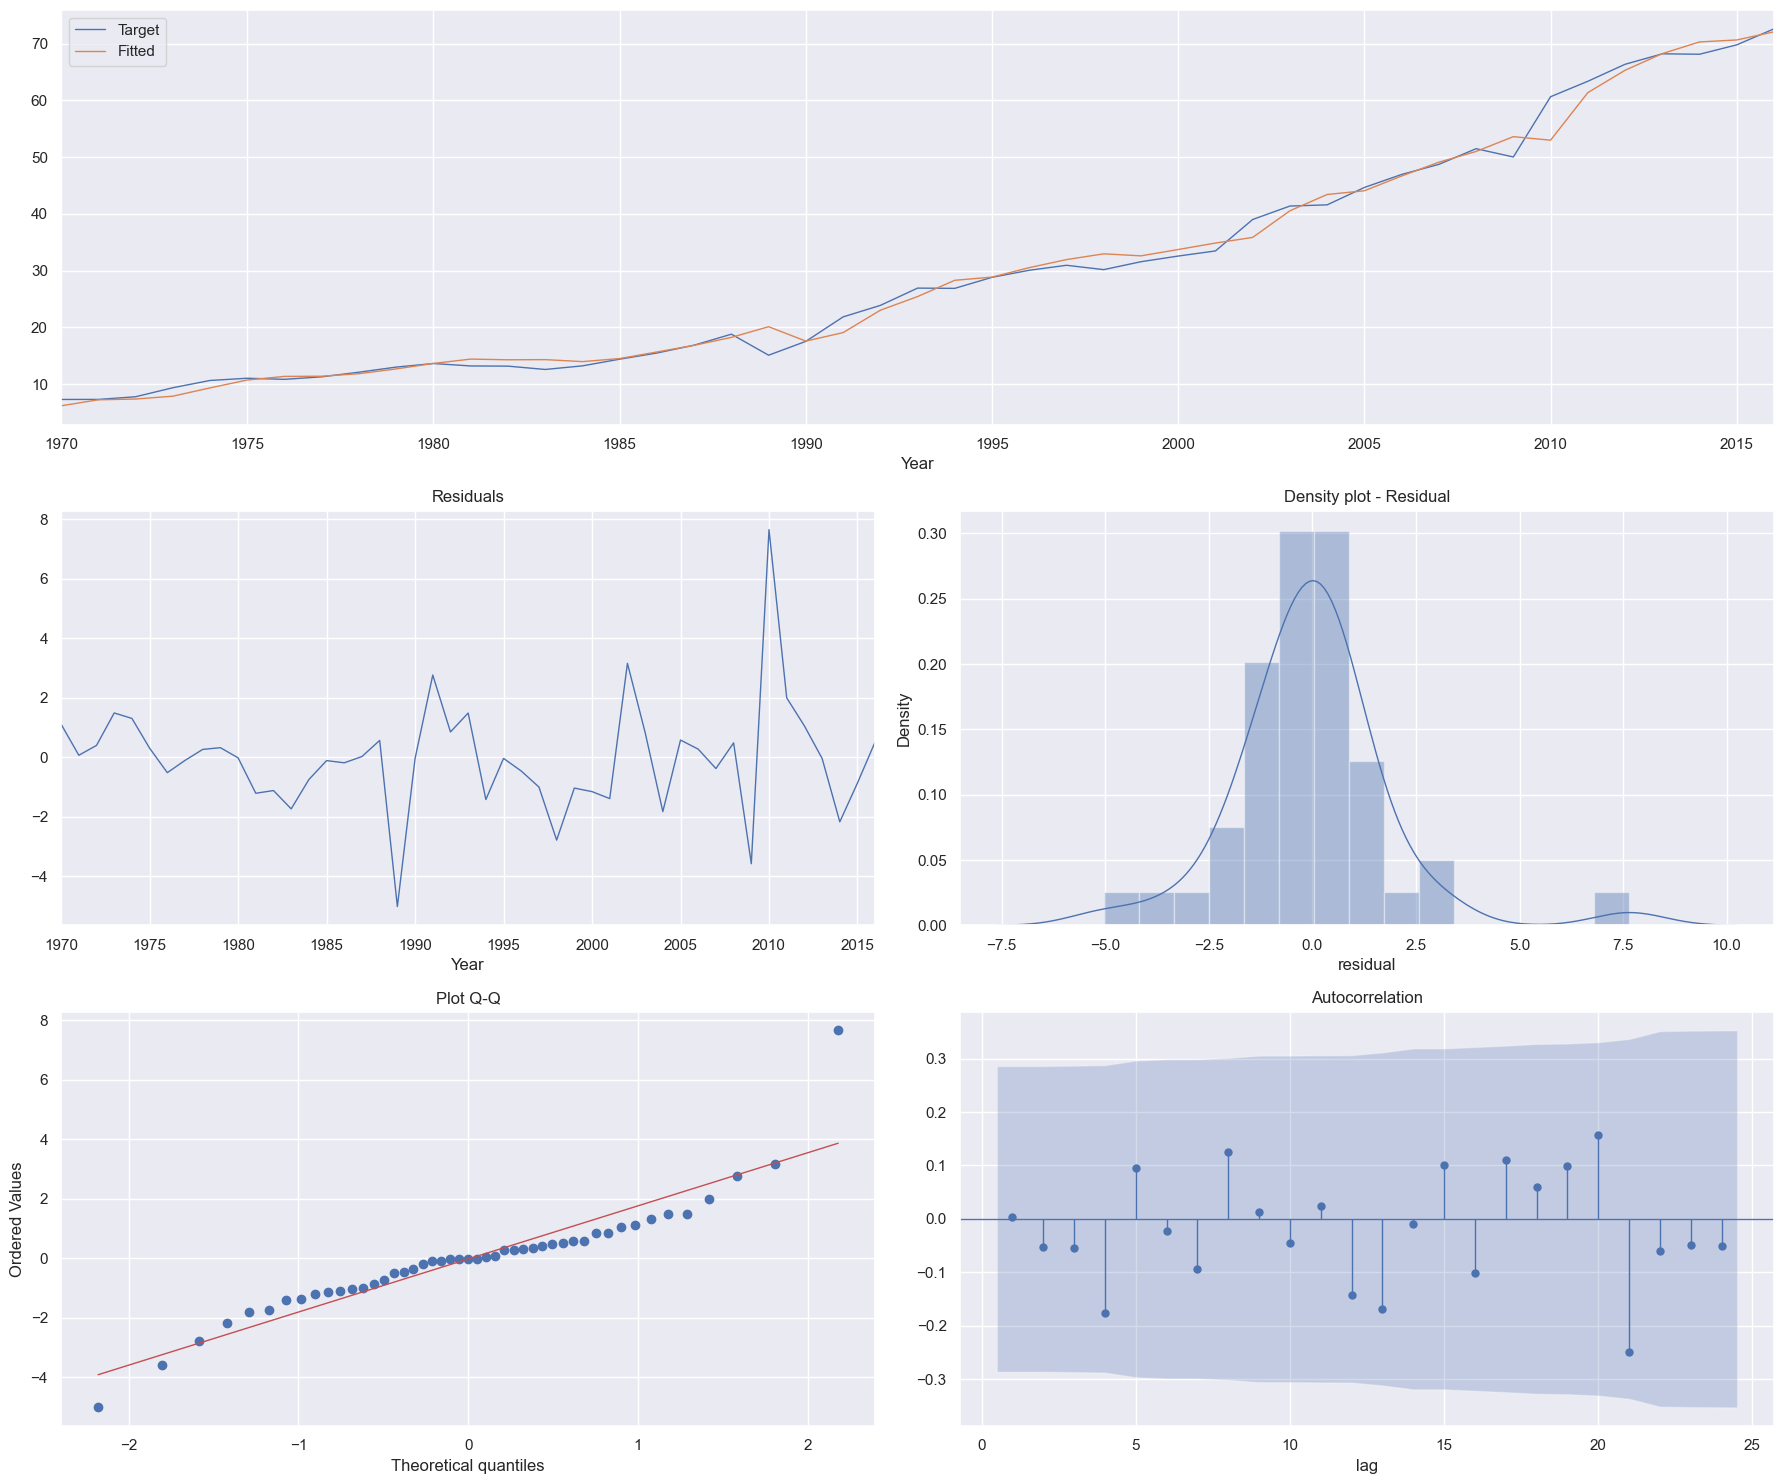

In [95]:
plot_fitted_residuals(fit)

In [26]:
df = passengers.reset_index()
df['unique_id'] = 1
df.columns=['ds', 'y', 'unique_id']

In [27]:
from statsforecast import StatsForecast

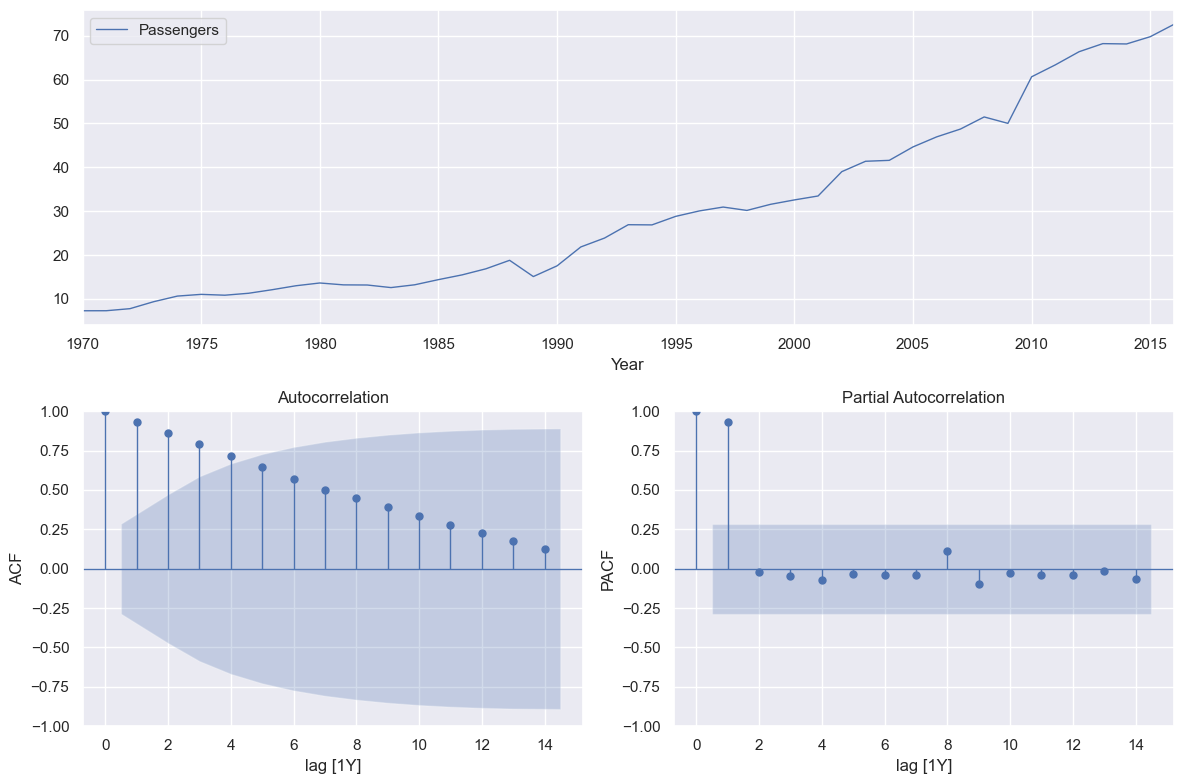

In [32]:
plot_autocorrelations(passengers, freq='Y', lags=np.r_[:15])

In [38]:
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [67]:
season_length = 1
models = [AutoARIMA()]

In [ ]:
sf = StatsForecast(df=df, models=models, freq='Y', n_jobs=-1)
sf.fit()

In [74]:
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(0,2,1)                   '

In [86]:
results = sf.fitted_[0, 0].model_
residual = pd.DataFrame(results.get('residuals'), columns=['residual Model'])

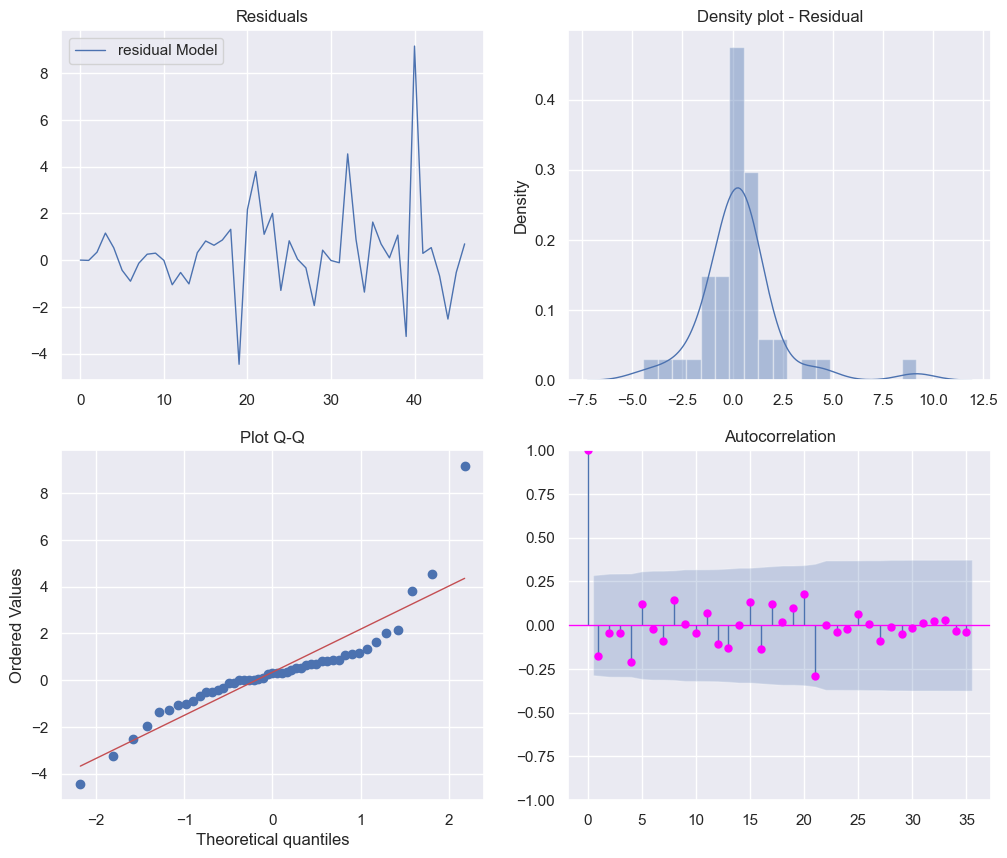

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();